## Programming Exercise 7: K-means Clustering and Principal Component Analysis

In [1]:
%matplotlib inline
import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
from random import sample #Used for random initialization
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
from scipy import linalg #Used for the "SVD" function

## 1 K-means Clustering

## 1.1 Implementing K-means

In [2]:
# Read in ex7data2.mac
datafile = 'data/ex7data2.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

# Choose the number of centroids... K = 3
K = 3
# Choose the initial centroids matching ex7.m assignment script
initial_centroids = np.array([[3,3], [6,2], [8,5]])

In [3]:
# Visualizing the data
def plotData(X, centroids, idxs = None):

    colors = ['b','g','gold','darkorange','salmon','olivedrab']

    assert X[0].shape == centroids[0][0].shape
    assert centroids[-1].shape[0] <= len(colors)

    # If idxs is supplied, divide up X into colors
    if idxs is not None:
        assert idxs.shape[0] == X.shape[0]
        subX = []
        for k in range(centroids[0].shape[0]):
            subX.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i] == k]))
    else:
        subX = [X]

    fig = plt.figure(figsize=(7,5))
    for row in range(len(subX)):
        plt.plot(subX[row][:, 0], subX[row][:, 1], 'o', color=colors[row], alpha=0.75, label='Data Points: Cluster %d'%row)

    plt.xlabel('x1', fontsize=14)
    plt.ylabel('x2', fontsize=14)
    plt.title('Plot of X Points', fontsize=16)
    plt.grid(True)

    # Drawing a history of centroid movement
    temp_x, temp_y = [], []
    for centroid in centroids:
        temp_x.append(centroid[:, 0])
        temp_y.append(centroid[:, 1])
    
    for row in range(len(temp_x[0])):
        plt.plot(temp_x, temp_y, 'rx--', markersize=8)

    leg = plt.legend(loc='upper right', framealpha=0.5)

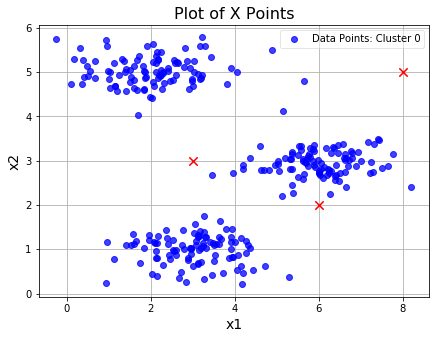

In [4]:
plotData(X, [initial_centroids])

### 1.1.1 Finding closest centroids

In [5]:
def distSquared(point1, point2):
    assert point1.shape == point2.shape
    return np.sum(np.square(point2-point1))

In [6]:
def findClosestCentroids(X, centroids):
    
    idxs = np.zeros([X.shape[0], 1])
    
    # Loop through each data point in X
    for x_row in range(X.shape[0]):
        point = X[x_row]
        # Compare this point to each centroid,
        # Keep track of shortest distance and index of shortest distance
        mindist, idx = distSquared(centroids[0], point), 0
        for k_row in range(centroids.shape[0]):
            centroid = centroids[k_row]
            distsquared = distSquared(centroid, point)
            if distsquared < mindist:
                mindist = distsquared
                idx = k_row
        # With the best index found, modify the result idx vector
        idxs[x_row] = idx
        
    return idxs

In [7]:
idxs = findClosestCentroids(X, initial_centroids)

# you should see the output [1 3 2] corresponding to the 
# centroid assignments for the first 3 examples.
# Note my indices start at 0, so I should see [0, 2, 1]
print(idxs[:10].flatten())

[ 0.  2.  1.  0.  0.  0.  0.  0.  0.  0.]


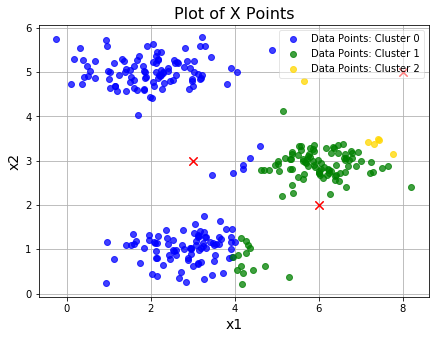

In [8]:
plotData(X, [initial_centroids], idxs)

### 1.1.2 Computing centroid means

In [9]:
def computeCentroids(X, idxs):
    cluster_X = []
    
    for row in range(len(np.unique(idxs))):
        cluster_X.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i] == row]))
    
    return np.array([np.mean(point, axis=0) for point in cluster_X])

## 1.2 K-means on example dataset

In [10]:
def runKMeans(X, initial_centroids, K, iter_nums):

    centroid_history = []

    current_centroids = initial_centroids

    for iter_num in range(iter_nums):
        centroid_history.append(current_centroids)
        idxs = findClosestCentroids(X, current_centroids)
        current_centroids = computeCentroids(X, idxs)

    return idxs, centroid_history

In [11]:
idxs, centroid_history = runKMeans(X, initial_centroids, K=3, iter_nums=10)

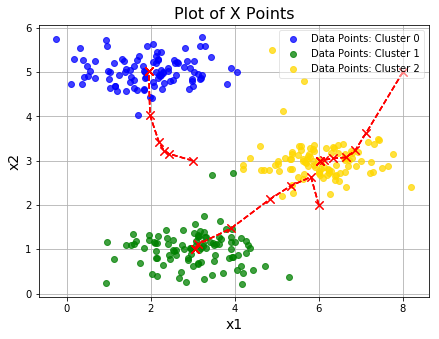

In [12]:
plotData(X, centroid_history, idxs)

## 1.3 Random initialization

In [13]:
def chooseKRandomCentroids(X, K):
    rand_indices = sample(range(0, X.shape[0]), K)
    return np.array([X[i] for i in rand_indices])

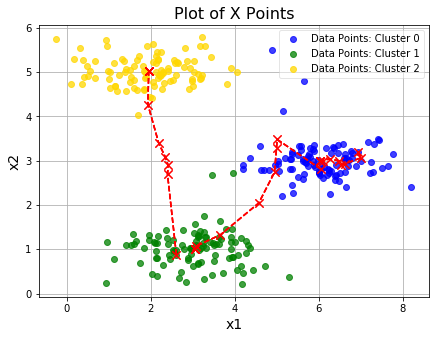

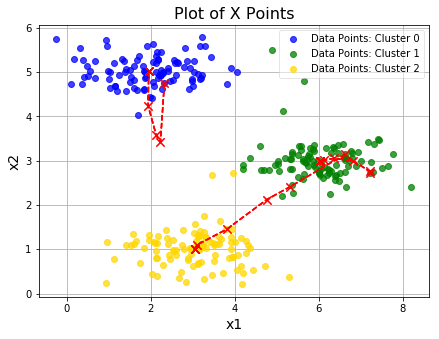

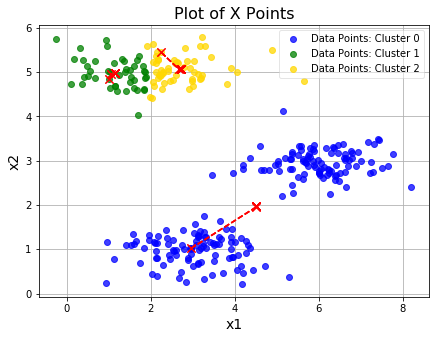

In [14]:
# Let's choose random initial centroids and see the resulting 
# centroid progression plot.. perhaps three times in a row
for x in range(3):
    idxs, centroid_history = runKMeans(X, chooseKRandomCentroids(X, K=3), K=3, iter_nums=10)
    plotData(X, centroid_history, idxs)

## 1.4 Image compression with K-means

### 1.4.1 K-means on pixels

original_img's shape is: (128, 128, 3)


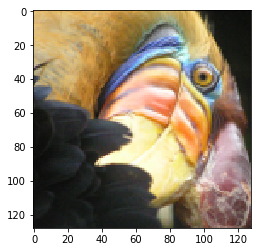

In [15]:
datafile = 'data/bird_small.png'

original_img = imageio.imread(datafile)

print("original_img's shape is:", original_img.shape)

plt.imshow(original_img)

In [16]:
# Divide every entry in A by 255 so all values are in the range of 0 to 1
img = original_img / 255.

# Unroll the image to shape (16384, 3) (16384 is 128*128)
img = img.reshape(-1, 3)

print("img's shape is:", img.shape)

# Run k-means on this data, forming 16 clusters, with random initialization
K = 16
idxs, centroid_history = runKMeans(img, chooseKRandomCentroids(img, K), K, iter_nums=10)

img's shape is: (16384, 3)


In [17]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating which of the 16 colors it should be
idxs = findClosestCentroids(img, centroid_history[-1])

In [18]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image that only has 16 colors in it
final_image = np.zeros([idxs.shape[0], 3])
for row in range(final_image.shape[0]):
    final_image[row] = final_centroids[int(idxs[row])]

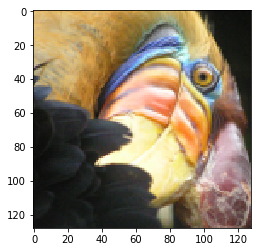

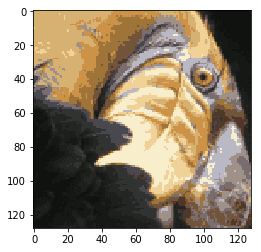

In [19]:
# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
plt.imshow(img.reshape(128, 128, 3))

plt.figure()
plt.imshow(final_image.reshape(128, 128, 3))

## 2 Principal Component Analysis

## 2.1 Example Dataset

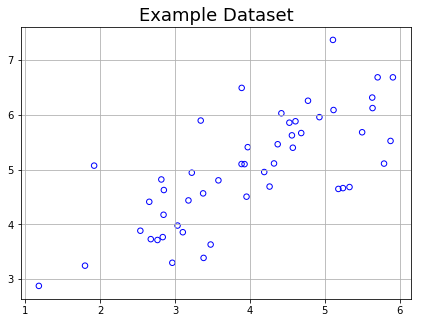

In [20]:
datafile = 'data/ex7data1.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']

# Quick plot
plt.figure(figsize=(7, 5))
plot = plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset", fontsize=18)
plt.grid(True)

## 2.2 Implementing PCA

In [21]:
def featureNormalize(X):
    #Feature-normalize X, return it
    means = np.mean(X, axis=0)
    X_norm = X - means
    stds  = np.std(X_norm, axis=0)
    X_norm = X_norm / stds
    return means, stds, X_norm

In [22]:
def getUSV(X_norm):
    # Compute the covariance matrix
    cov_matrix = X_norm.T.dot(X_norm) / X_norm.shape[0]
    # Run single value decomposition to get the U principal component matrix
    U, S, V = scipy.linalg.svd(cov_matrix, full_matrices = True, compute_uv = True)
    return U, S, V

In [23]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)

print('means: ', means)
print('\nU: ', U)
print('\nS: ', S)
print('\nV: ', V)

means:  [ 3.98926528  5.00280585]

U:  [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

S:  [ 1.73553038  0.26446962]

V:  [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


Top principal component is  [-0.70710678 -0.70710678]


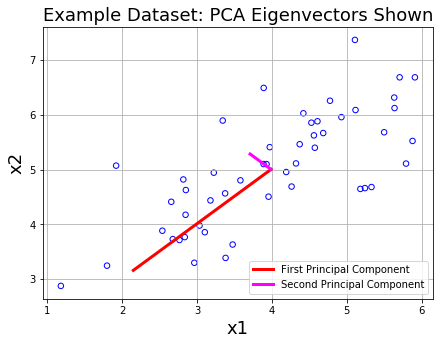

In [24]:
# "output the top principal component (eigen-vector) found, and you should expect to see an output of about [-0.707 -0.707]"
print('Top principal component is ', U[:, 0])

# Quick plot, now including the principal component
plt.figure(figsize=(7, 5))
plot = plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset: PCA Eigenvectors Shown", fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
plt.grid(True)

# To draw the principal component, you draw them starting at the mean of the data
plt.plot([means[0], means[0] + 1.5*S[0]*U[0, 0]],
         [means[1], means[1] + 1.5*S[0]*U[0, 1]],
         color='red',
         linewidth=3,
         label='First Principal Component')

plt.plot([means[0], means[0] + 1.5*S[1]*U[1, 0]],
         [means[1], means[1] + 1.5*S[1]*U[1, 1]],
         color='fuchsia',
         linewidth=3,
         label='Second Principal Component')

leg = plt.legend(loc=4)

## 2.3 Dimensionality Reduction with PCA

## 2.3.1 Projecting the data onto the principal components

In [25]:
def projectData(X, U, K):
    # Reduced U is the first "K" columns in U
    Ureduced = U[:, :K]
    z = X.dot(Ureduced)
    return z

In [26]:
# "...project the first example onto the first dimension and you should see a value of about 1.481"
z = projectData(X_norm, U, 1)
print('Projection of the first example is %0.3f.' % float(z[0]))

Projection of the first example is 1.496.


## 2.3.2 Reconstructing an approximation of the data

In [27]:
def recoverData(Z, U, K):
    Ureduced = U[:, :K]
    Xapprox = Z.dot(Ureduced.T)  
    return Xapprox

In [28]:
X_rec = recoverData(z, U, 1)
print('Recovered approximation of the first example is ', X_rec[0])

Recovered approximation of the first example is  [-1.05805279 -1.05805279]


## 2.3.3 Visualizing the projections

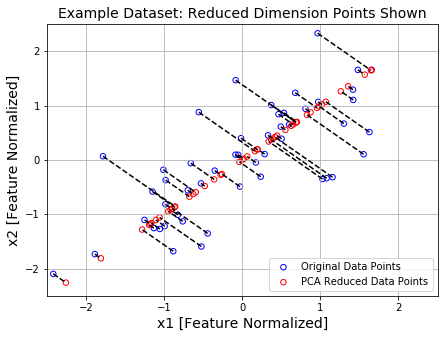

In [29]:
# Quick plot, now drawing projected points to the original points
plt.figure(figsize=(7, 5))
plot = plt.scatter(X_norm[:, 0], X_norm[:, 1], s=30, facecolors='none', edgecolors='b', label='Original Data Points')
plot = plt.scatter(X_rec[:, 0], X_rec[:, 1], s=30, facecolors='none', edgecolors='r', label='PCA Reduced Data Points')

plt.title('Example Dataset: Reduced Dimension Points Shown', fontsize=14)
plt.xlabel('x1 [Feature Normalized]', fontsize=14)
plt.ylabel('x2 [Feature Normalized]', fontsize=14)
plt.grid(True)

for row in range(X_norm.shape[0]):
    plt.plot([X_norm[row, 0], X_rec[row, 0]], [X_norm[row, 1], X_rec[row, 1]], 'k--')

leg = plt.legend(loc=4)

# Force square axes to make projections look better
dummy = plt.xlim([-2.5, 2.5])
dummy = plt.ylim([-2.5, 2.5])

## 2.4 Face Image Dataset

In [30]:
datafile = 'data/ex7faces.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']

In [31]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x1032,
    crates an image object from it, and returns it
    """
    width, height = 32, 32
    square = row.reshape(width, height)
    return square.T
    
def displayData(X, rows = 10, cols = 10):
    """
    Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 32, 32
    nrows, ncols = rows, cols

    big_picture = np.zeros([height*nrows, width*ncols])
    
    irow, icol = 0, 0
    for idx in range(nrows*ncols):
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height: irow*height+iimg.shape[0], icol*width: icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(10, 10))
    img = scipy.misc.toimage(big_picture)
    plt.imshow(img, cmap = cm.Greys_r)

/Users/mvpzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


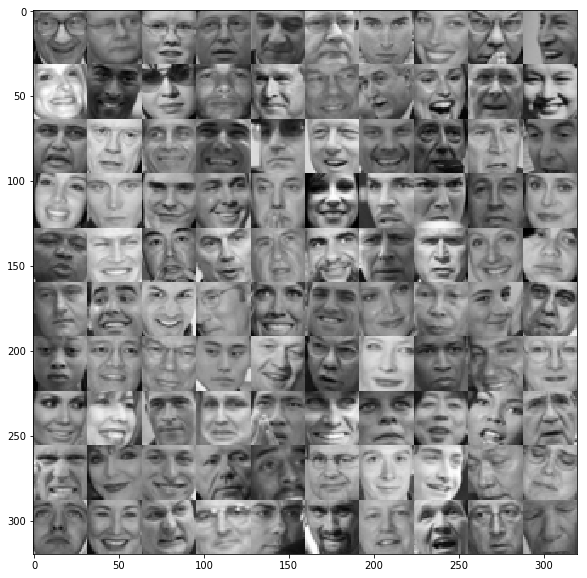

In [32]:
displayData(X)

## 2.4.1 PCA on Faces

In [33]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)

/Users/mvpzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


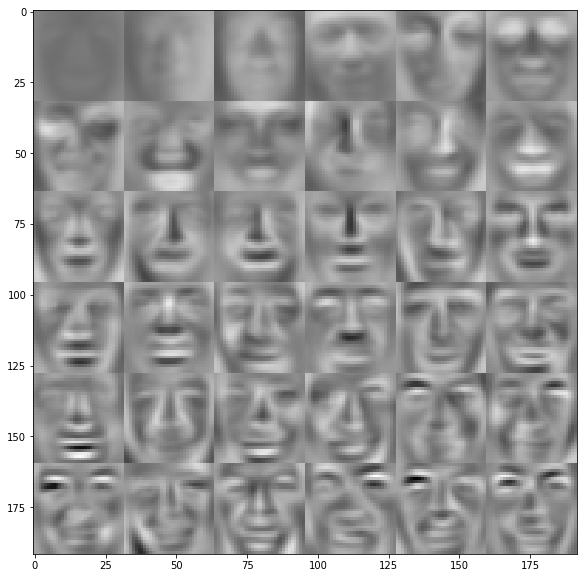

In [34]:
# Visualize the top 36 eigenvectors found
# "Eigenfaces" lol
displayData(U[:, :36].T, rows=6, cols=6)

## 2.4.2 Dimensionality Reduction

In [35]:
# Project each image down to 36 dimensions
z = projectData(X_norm, U, K=36)

In [36]:
# Attempt to recover the original data
X_rec = recoverData(z, U, K=36)

/Users/mvpzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


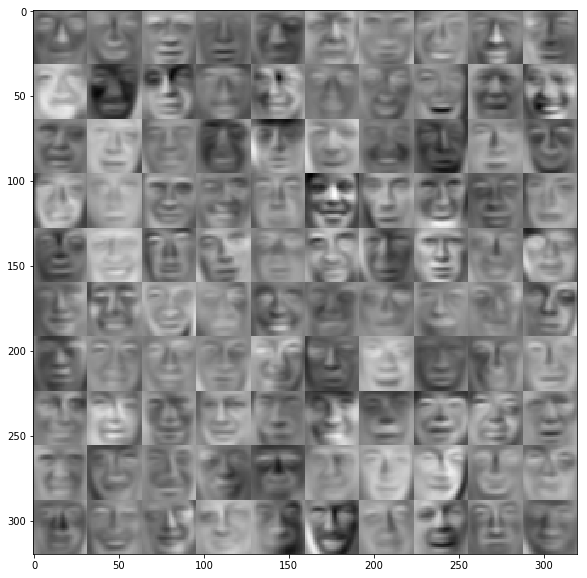

In [37]:
# Plot the dimension-reduced data
displayData(X_rec)